# Final Project CS209b
## Conditional Autoregression (CAR) Covid & Flu - May 5
### Benjamin Levy, Will Fried, Dimitris Vamvourellis & Matthieu Meeus

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_squared_error
import math
import pymc3 as pm
from theano import shared, scan
import theano
import theano.tensor as tt
from pymc3.distributions import continuous
from pymc3.distributions import distribution
from sklearn.model_selection import train_test_split
floatX = "float32"

#### Introduction

As in the spirit of the entire project, this notebook will attempt to gain knowledge from 10 years of data on the flu and embed this information in a model to better understand the spread of Covid-19. Here we will dive into a Conditional AutoRegressive (CAR) model. This is a hierarchical model typically applied to spatially autocorrelated data, where neighborhood relationships can be leveraged to improve predictions. The notebook is built as follows:

- First, the flu and covid data are loaded and briefly investigated. 
- Second, the overall idea of the CAR model and its application to the problem at hand is discussed. 
- Finally, the models can actually be built and evaluated. 

### 1. Get the data

#### 1.1 Flu data

In [4]:
flu_data = pd.read_csv('flu_ground_truth_imputed.csv')
flu_data = flu_data.reindex(sorted(flu_data.columns), axis=1)
flu_data.head()

,Alabama,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Georgia,Idaho,Illinois,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,2.13477,0.674721,0.696056,1.95412,0.660684,0.078309,0.100125,1.60490,0.414938,1.28205,...,1.102750,0.274655,2.06514,0.747696,1.47641,1.14343,0.510041,1.59741,0.465022,0.632911
1,2.05999,0.749939,0.674157,2.15266,0.628621,0.238095,0.368550,1.71307,1.457980,1.45089,...,0.793794,0.499492,2.09394,0.410939,1.35777,1.23653,1.040070,1.58968,0.581832,0.440621
2,1.94224,0.953365,0.514217,2.24173,0.804020,0.374158,0.337025,2.01249,1.408140,1.56607,...,0.791023,0.499550,2.10072,0.440583,1.48221,1.22545,0.904393,1.52672,1.188220,0.441798
3,2.27650,0.888804,0.413650,1.91748,0.909658,0.333542,0.460494,2.38747,1.280070,1.45762,...,0.801311,0.401638,2.20655,0.755957,1.44393,1.26902,0.955110,1.81171,1.010490,0.490305
4,2.83371,1.185730,1.090280,2.52326,0.971705,0.396743,0.222332,2.65614,1.827240,1.48930,...,0.779833,0.528096,2.36381,0.651859,1.25276,1.26547,0.786370,1.83986,1.096490,0.566636


In [10]:
# check the NaN
nans = []
for state_name in flu_data.columns:
    if state_name != 'time':
        nans_state = flu_data[state_name].isna().sum()
        if nans_state != 0:
            print('For {}, there are {} NaNs'.format(state_name, nans_state))
            nans.append(nans_state)
if len(nans) == 0:
    print('There are no NaNs!')

There are no NaNs!


#### 1.2 Covid data

For the Covid-19 data, we found that the New York Times released a publicly available dataset (source:https://data.humdata.org/dataset/nyt-covid-19-data). It contains the daily number of recorded cases per US state since January 21 2020, which was the date of the first confirmed case in the US. 

In [11]:
covid_data = pd.read_csv('Covid_data.csv')
covid_data.head()

,Unnamed: 0,date,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,0,2020-01-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
1,1,2020-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
2,2,2020-01-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
3,3,2020-01-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
4,4,2020-01-25,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN


Text(0.5, 1.0, 'Covid-19 cases per US state over time')

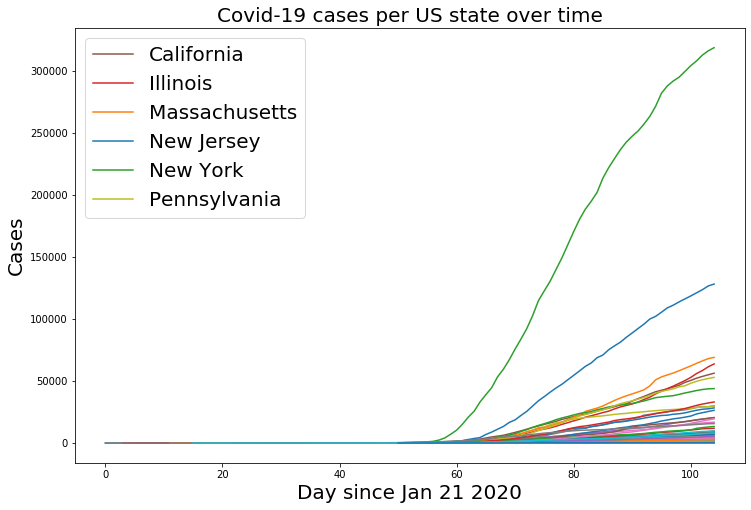

In [4]:
plt.figure(figsize = (12,8))
for state_name in covid_data.columns:
    if state_name != 'date':
        if covid_data[state_name].values[-1]>50000:
            plt.plot(range(len(covid_data)), covid_data[state_name], label = state_name)
        else:
            plt.plot(range(len(covid_data)), covid_data[state_name])
plt.xlabel('Day since Jan 21 2020', fontsize = 20)
plt.ylabel('Cases', fontsize = 20)
plt.legend(fontsize = 20)
plt.title('Covid-19 cases per US state over time', fontsize = 20)

### 2. Conditional Autoregression: Theory

#### 2.1 General CAR

We will first discuss the conditional autoregressive (CAR) model in general. It is widely used to model the spatial variation of the response variable $y_i$, where it is assumed that the probability of values estimated for a variable $z_i$ are conditional on neighboring values $z_j$. As such, it is a natural way to study the spatial relations present in specific data. It is thus potentially interesting to apply a CAR model to our geographically spread data on deseases. 

Consider a general Spatial Regression Model (SAR) to start with:

$$y_i = X_i\beta + z_i + \epsilon_i$$

Where:

- $y_i$ is the response variable at node i, 
- $X_i$ the predictor variables measured at the same node i as $y_i$, 
- $\beta$ the local regression coefficients,
- $z_i$ a latent spatial random error $z_i \sim N(0, \Sigma_i)$,
- $\epsilon_i$ an independent error $\epsilon_i \sim N(0, \sigma_{\epsilon_i}^2)$

In the Conditional AR model, the $z_i$ variable depends on the neighbouring values $z_j$ for $i \neq j$:

$$z_i | z_j, i \neq j \sim N(\sum_{j \neq i} c_{ij} z_j, m_{ii})$$

Where $c_{ii} = 0$. As such, there are three main contributions to the response variable $y_i$: a regression of locally measured predictors, a conditional spatial term and a random error that is specific to the location. The matrix $C$ is often developed as $\rho W$ where $W$ is the 'neighborhood matrix' and $\rho$ an autocorelation factor. Matrix $W$ contains the underlying relationship between the nodes present in the problem in the form of values $w_{ij}$ that is a proxy for the 'weighted spatial impact' of node j on node i. 

Reference to: https://eprints.qut.edu.au/115891/1/115891.pdf

#### 2.2 CAR applied to time series of state-dependent desease spread

The CAR model sounds like a very interesting idea to apply to a time-series of spread of deseases per state. First, it is natural that each state corresponds to 1 node i. Next, we can easily embed the temporal factor in a similar way to regular AutoRegression for time series, where the previous observations serve as 'local' predictors. The spatial factor then comes in as before. More specifically:

$$Y_{ti} = \beta X_i + z_i + \epsilon_i$$

Where:

- $Y_{ti}$ is for instance the Wili rate in state i at time t. We still want to predict the response variable over time at a specific location, so this remains the response variable. 
- $X_i$ is a vector containing all the 'local' predictors. In the case of a AR time series model, this will contain the N previous Wili observations in time in state i.
- $\beta$ is a vector containing the local AR time-lag-regression coefficients. 
- $z_i$ is the latent spatial random error, which will be conditional on the neighbouring states, where neighbour still needs to be defined. 
- $\epsilon_i$ an independent error $\epsilon_i \sim N(0, \sigma_{\epsilon_i}^2)$

The spatial factors can then still be determined in the same way:

$$z_i | z_j, i \neq j \sim N(\sum_{j \neq i} c_{ij} z_j, m_{ii})$$

Following standard practice, we can define the matrix $C = \rho W$. Now it comes down to come up with a reasonable value for the correlation variable $\rho$ and the construction of neighbor matrix $W$. 

#### 2.3 Final model decision

The initial idea was to apply the CAR model to the flu, where the weights of the neighbour matrix W would be drawn from a distribution that depends on the state statistics. However, we realized that:
- this would be tricky to fit using PyMC3 and that 
- this is not the goal of CAR models, **as the 'neighbour' characteristic should be intrinsic to the problem.**  

As such, it would make more sense to use the model with clever, fixed values for the coefficients in W. That's where the flu data can leveraged in modeling Covid! **We will use the 10 years of Wili data in all states to come up with a reasonable construction of W, capturing the definition of 'neighbour' for all states in the context of the spread of a desease. We will then be able to use this fixed W to model state-specific spread of Covid-19 for all US states.** 

### 3. Building the model

There will be two big steps here: 
- Construct W using the flu data. 
- Build the CAR model for Covid using this W

Nice resource: https://docs.pymc.io/notebooks/PyMC3_tips_and_heuristic.html

#### 3.1 Construct W

How does one capture the similarity between different states for a set of time series? The first thing that comes to mind is correlation! Let's start by constructing W with

$$w_{ij} = \rho_{ij}$$

Where $\rho_{ij}$ corresponds to the correlation of the 10 year time series of state i with the 10 year time series of state j. 

In [12]:
# this comes down to the following:
corr_df = flu_data.corr()
W_0 = corr_df.values
corr_df

,Alabama,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Georgia,Idaho,Illinois,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
Alabama,1.000000,0.478343,0.804118,0.745767,0.496352,0.474025,0.570794,0.736040,0.730024,0.829481,...,0.686713,0.777963,0.742456,0.557445,0.477523,0.725261,0.657645,0.733572,0.645269,0.669118
Arizona,0.478343,1.000000,0.708655,0.624341,0.654468,0.812346,0.495609,0.647942,0.344441,0.606932,...,0.708217,0.606541,0.730329,0.510944,0.473265,0.679351,0.647333,0.714140,0.693518,0.755155
Arkansas,0.804118,0.708655,1.000000,0.750759,0.678221,0.725350,0.689495,0.745959,0.692205,0.821421,...,0.824818,0.844728,0.885748,0.602684,0.593476,0.847689,0.751945,0.882243,0.788724,0.820194
California,0.745767,0.624341,0.750759,1.000000,0.557047,0.545393,0.670669,0.549149,0.793012,0.811212,...,0.729570,0.652448,0.698371,0.677204,0.685699,0.673084,0.822332,0.744080,0.643885,0.692586
Colorado,0.496352,0.654468,0.678221,0.557047,1.000000,0.681971,0.525839,0.611973,0.471650,0.528150,...,0.547445,0.624236,0.683565,0.716789,0.507319,0.737040,0.636994,0.695676,0.592375,0.696151
Connecticut,0.474025,0.812346,0.725350,0.545393,0.681971,1.000000,0.562150,0.655122,0.386422,0.599743,...,0.729913,0.641301,0.744400,0.549368,0.556395,0.757206,0.598256,0.745923,0.754141,0.762897
Delaware,0.570794,0.495609,0.689495,0.670669,0.525839,0.562150,1.000000,0.523313,0.590265,0.618741,...,0.643659,0.638965,0.651821,0.614070,0.748145,0.753904,0.633755,0.699116,0.597324,0.736432
Georgia,0.736040,0.647942,0.745959,0.549149,0.611973,0.655122,0.523313,1.000000,0.431887,0.705215,...,0.707429,0.745287,0.776738,0.410640,0.370001,0.795916,0.579205,0.706390,0.664093,0.750287
Idaho,0.730024,0.344441,0.692205,0.793012,0.471650,0.386422,0.590265,0.431887,1.000000,0.698748,...,0.610004,0.624343,0.612717,0.625770,0.608958,0.601447,0.738933,0.683131,0.596878,0.556861
Illinois,0.829481,0.606932,0.821421,0.811212,0.528150,0.599743,0.618741,0.705215,0.698748,1.000000,...,0.781121,0.807857,0.833891,0.650454,0.549782,0.794949,0.741555,0.766999,0.773869,0.756345


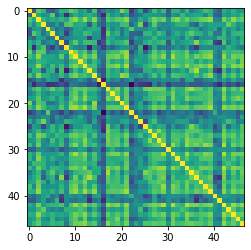

In [13]:
plt.imshow(W_0)

Although the correlation would make sense as weight between states, we would miss out on an important aspect of the definition of 'neighbour', being that a state can only have a limited amount of neighbours. So ideally, we wish to make W a sparse matrix, where only the coefficients corresponding to the highest correlation between states i and j are non-zero. 

Driving the least important coefficients to exactly zero sounds like LASSO! **So let's build a plain vanilla linear regression model for each state's time series, using all the other states as predictors. We'll fit the model using a strong $l_1$-regularization, which will lead to only a limited amount of non-zero coefficients.** Note that the Lasso Sklearn implementation has an attribute 'positive' which makes sure the model only considers positive values for the coefficients. 

In [14]:
from sklearn.linear_model import Lasso

lamb = 0.01
N = len(flu_data.columns)
W = np.zeros((N,N))

for i, state_name in enumerate(flu_data.columns):
    y = flu_data[state_name].values
    df_to_work_with = flu_data.drop([state_name], axis = 1)
    X = df_to_work_with.values
    lasso_obj = Lasso(alpha = lamb, positive = True)
    lasso_obj.fit(X,y)
    coef = lasso_obj.coef_
    left = coef[:i]
    right = coef[i:]
    W[i,:i] = left
    W[i, i+1:] = right

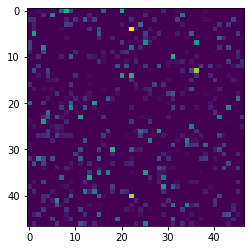

In [15]:
plt.imshow(W)

This looks like a reasonable sparsity for a neighborhood definition!

In [16]:
# let's check the results and compare to the correlation

for i, state_name in enumerate(flu_data.columns[:5]):
    neighbors = []
    coefs = []
    for k, coef in enumerate(W[i,:]):
        if coef > 0:
            coefs.append(coef)
            neighbors.append(flu_data.columns[k])
    n_neigh = len(neighbors)
    max_coefs = np.array(coefs).argsort()[::-1][1:n_neigh+1]
    neighbors = np.array(neighbors)[max_coefs]
    print('For state {}, the identified neighbours are: '.format(state_name))
    print(list(neighbors))
    # let's compare to the states with the highest correlation
    corr_list = W_0[i, :].copy()
    max_coefs = corr_list.argsort()[::-1][1:n_neigh+1]
    max_corr_states = flu_data.columns[max_coefs]
    print('The max correlation states were: ')
    print(list(max_corr_states))
    print('------------')

For state Alabama, the identified neighbours are: 
['Mississippi', 'Georgia', 'Maryland', 'Illinois', 'North Carolina', 'Oklahoma', 'Tennessee', 'Arkansas']
The max correlation states were: 
['Mississippi', 'Illinois', 'Arkansas', 'Indiana', 'Louisiana', 'Tennessee', 'Missouri', 'New Mexico', 'North Carolina']
------------
For state Arizona, the identified neighbours are: 
['Oregon', 'California', 'New Hampshire', 'Kentucky', 'Wisconsin']
The max correlation states were: 
['Connecticut', 'Massachusetts', 'Oregon', 'Wyoming', 'Kentucky', 'Texas']
------------
For state Arkansas, the identified neighbours are: 
['West Virginia', 'Oklahoma', 'Louisiana', 'Arizona', 'Indiana', 'Alabama', 'Montana', 'New Mexico', 'Idaho', 'Kentucky', 'Tennessee', 'Texas', 'South Dakota']
The max correlation states were: 
['Kansas', 'Texas', 'West Virginia', 'Indiana', 'Missouri', 'Oklahoma', 'Louisiana', 'New Mexico', 'Virginia', 'Tennessee', 'North Carolina', 'Pennsylvania', 'Ohio', 'South Dakota']
-------

Clearly, the states returned by Lasso sometimes match with the highest correlation, and sometimes they don't. Because we still believe in the truth embedded in the Lasso coefficients, we'll move forward using this as neighborhood matrix. 

#### 3.2 CAR model for Covid

Let's formalize the final model:

$$Y_{ti} \sim Poisson(exp(\beta X_i + z_i))$$

Where:

- $Y_{ti}$ is number of Covid cases in state i at time t. 
- $X_i$ is a vector containing all the 'local' predictors. In the case of a AR time series model, this will contain the N previous case counts observations in time in state i.
- $\beta$ is a vector containing the local AR time-lag-regression coefficients, and is considered to be different for each state. We'll use a normal distribution as prior: $\beta_i \sim N(0, \sigma_b^2)$. 
- $z_i$ is the latent spatial random error, which will be conditional on the neighbouring states, or more formally:

$$z_i | z_j, i \neq j \sim N(\sum_{j \neq i} c_{ij} z_j, m_{ii})$$
  
  Where matrix $C = \rho W$, $\rho$ the correlation factor (to be tuned) and matrix $W$ as computed above. 

In [17]:
# prepare data
covid_data.drop(['Unnamed: 0', 'date', 'Alaska','District of Columbia', 'Hawaii'], axis = 1, inplace = True)
# and make sure we have the same states as in W
print(covid_data.columns)
print(flu_data.columns)

Index(['Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Georgia', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri',
       'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey',
       'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio',
       'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia',
       'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype='object')
Index(['Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Georgia', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri',
       'Montana', 'Nebraska', 'N

### Let's start by one lag and one prediction ahead!

In [18]:
lag = 1
pred_ahead = 1

# let's start from day 56 to avoid too many NaNs
start = 56
state2idx = {name : int(idx) for idx, name in enumerate(covid_data.columns)}

# create DF
CAR_df = pd.DataFrame(columns = ['Y_true_ahead', 'Y_true_before', 'Y_perc'] + 
                      ['State ID'] + ['X_lag{}'.format(i) for i in range(1, lag+1)])

row_num = 0
for i, day in enumerate(range(start + lag, len(covid_data) - pred_ahead)):
    for state in covid_data.columns:
        # do Y percentage increase and X last percentage increase
        Y_true_ahead = covid_data[state][day + pred_ahead]
        Y_true_before = covid_data[state][day]
        pred_Y = Y_true_ahead/Y_true_before
        lag_X = [covid_data[state][day - step]/covid_data[state][day - step -1] for step in range(1, lag+1)]
        CAR_df.loc[row_num] = [Y_true_ahead, Y_true_before, pred_Y] + [state2idx[state]] + lag_X
        row_num += 1

CAR_df.head()

,Y_true_ahead,Y_true_before,Y_perc,State ID,X_lag1
0,78.0,51.0,1.529412,0.0,1.344828
1,47.0,28.0,1.678571,1.0,1.111111
2,62.0,33.0,1.878788,2.0,1.000000
3,1067.0,893.0,1.194849,3.0,1.244898
4,278.0,216.0,1.287037,4.0,1.136646


In [19]:
df_train, df_test = train_test_split(CAR_df, test_size=0.2, random_state=42)

In [20]:
len(df_train)

1767

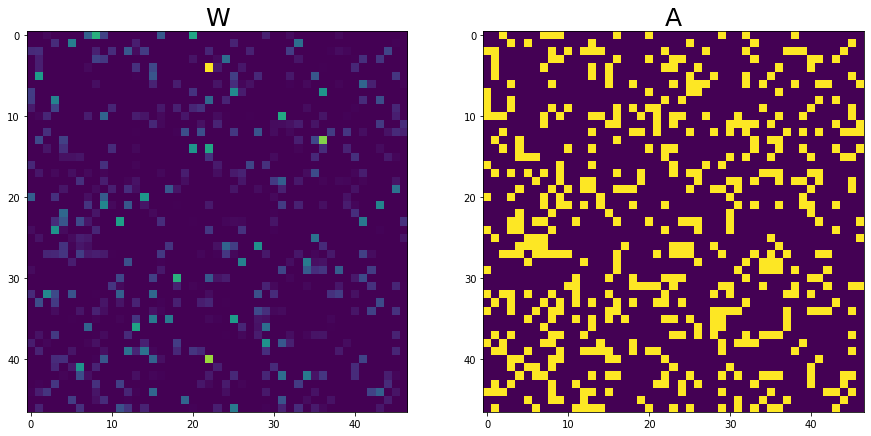

In [21]:
# create wmat2 and amat2
rho = 0.2
wmat2 = rho*W
amat2 = np.zeros((N, N), dtype='int32')

for row in range(N):
    for col in range(N):
        if wmat2[row,col] > 0:
            amat2[row][col] = 1
            
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].imshow(wmat2)
ax[0].set_title('W', fontsize = 25)
ax[1].imshow(amat2)
ax[1].set_title('A', fontsize = 25);

In [22]:
W.shape

(47, 47)

In [23]:
# define the CAR layer

class CAR2(distribution.Continuous):
    """
    Conditional Autoregressive (CAR) distribution

    Parameters
    ----------
    a : adjacency matrix
    w : weight matrix
    tau : precision at each location
    """

    def __init__(self, w, a, tau, *args, **kwargs):
        super(CAR2, self).__init__(*args, **kwargs)
        self.a = a = tt.as_tensor_variable(a)
        self.w = w = tt.as_tensor_variable(w)
        self.tau = tau*tt.sum(w, axis=1)
        self.mode = 0.

    def logp(self, x):
        tau = self.tau
        w = self.w
        a = self.a

        mu_w = tt.sum(x*a, axis=1)/tt.sum(w, axis=1)
        return tt.sum(continuous.Normal.dist(mu=mu_w, tau=tau).logp(x))

In [24]:
N = 47

with pm.Model() as model2:
    # Vague prior on intercept
    beta0 = pm.Normal('beta0', mu=0.0, tau=1.0e-5, shape = N)
    # Prior on local time regression
    betas = pm.Normal('betas', mu=0.0, tau = 1.0e-5, shape = N)

    # Random effects (hierarchial) prior
    tau_h = pm.distributions.continuous.Gamma('tau_h', alpha=3.2761, beta=1.81)
    # Spatial clustering prior
    tau_c = pm.distributions.continuous.Gamma('tau_c', alpha=1.0, beta=1.0)
    
    Z = pm.Normal('Z_aux', mu = 0.0, sigma = 1.0, shape = len(df_train))
    theta = Z/np.sqrt(tau_h)
    
    # Regional random effects
    #theta = pm.Normal('theta', mu=0.0, tau=tau_h, shape=len(df_train))
    mu_phi = CAR2('mu_phi', w=wmat2, a=amat2, tau=1.0e-5, shape=N)

    # Zero-centre phi
    phi = pm.Deterministic('phi', mu_phi-tt.mean(mu_phi))

    # Mean model
    CAR_model_combo = beta0[np.array([int(i) for i in df_train['State ID'].values])]
    CAR_model_combo += betas[np.array([int(i) for i in df_train['State ID'].values])]*df_train['X_lag1'].values
    CAR_model_combo += phi[np.array([int(i) for i in df_train['State ID'].values])]
    CAR_model_combo += theta
    mu = pm.Deterministic('mu', tt.exp(CAR_model_combo))

    # Likelihood
    tau_final = pm.distributions.continuous.Gamma('tau_final', alpha=1, beta=1)
    Yi = pm.Normal('Yi', mu=mu, tau = tau_final, observed=df_train['Y_perc'])

    # Marginal SD of heterogeniety effects
    sd_h = pm.Deterministic('sd_h', tt.std(theta))
    # Marginal SD of clustering (spatial) effects
    sd_c = pm.Deterministic('sd_c', tt.std(phi))
    # Proportion sptial variance
    alpha = pm.Deterministic('alpha', sd_c/(sd_h+sd_c))

In [19]:
for RV in model2.basic_RVs:
    print(RV.name, RV.logp(model2.test_point))

beta0 -313.7438594874203
betas -313.7438594874203
tau_h_log__ -0.35097140933173876
tau_c_log__ -1.0
Z_aux -1623.7643881726965
mu_phi -350.14373473069503
tau_final_log__ -1.0
Yi -1655.9623166281951


In [20]:
with model2:
    print(f'Starting MCMC process') 
    trace2 = pm.sample(2000, tune=1000, target_accept=0.98, cores = 8, max_treedepth = 12, init='adapt_diag')
    print(f'DONE')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


Starting MCMC process


Multiprocess sampling (8 chains in 8 jobs)
NUTS: [tau_final, mu_phi, Z_aux, tau_c, tau_h, betas, beta0]
Sampling 8 chains, 0 divergences: 100%|██████████| 24000/24000 [4:31:34<00:00,  1.47draws/s]  
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Inc

DONE


In [23]:
summ = pm.summary(trace2)
summ.to_csv('CARModelLag1.csv')
summ

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta0[0],-4.789,22.662,-63.115,28.631,6.045,4.367,14.0,14.0,12.0,16.0,1.81
beta0[1],-8.489,35.624,-73.351,68.681,11.557,8.437,10.0,10.0,10.0,10.0,2.24
beta0[2],-2.427,23.377,-29.551,55.504,7.811,5.714,9.0,9.0,10.0,24.0,2.29
beta0[3],5.519,25.079,-34.183,61.897,7.446,5.407,11.0,11.0,11.0,15.0,1.87
beta0[4],5.344,18.078,-25.327,41.949,3.932,2.820,21.0,21.0,15.0,45.0,1.70
...,...,...,...,...,...,...,...,...,...,...,...
mu[1766],1.155,0.063,1.040,1.270,0.005,0.004,139.0,139.0,140.0,318.0,1.04
tau_final,190.716,15.453,167.515,221.423,2.817,2.012,30.0,30.0,26.0,66.0,1.22
sd_h,0.082,0.001,0.080,0.085,0.000,0.000,59.0,59.0,59.0,252.0,1.11
sd_c,28.878,5.801,19.144,41.337,1.760,1.299,11.0,11.0,11.0,23.0,1.89


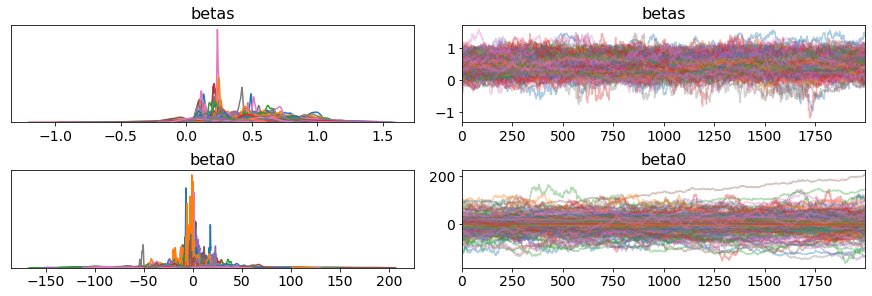

In [24]:
pm.traceplot(trace2, var_names=['betas', 'beta0']);

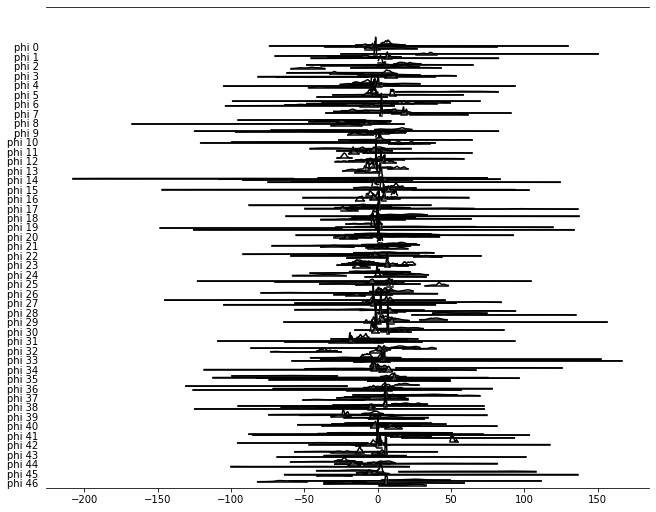

In [25]:
pm.plot_forest(trace2,
               kind='ridgeplot',
               var_names=['phi'],
               combined=False,
               ridgeplot_overlap=3,
               ridgeplot_alpha=.25,
               colors='white',
               figsize=(9, 7));

In [26]:
# prediction
# let's save the parameters for each district into a dict
# params_dict[state] = [beta1, phi]
params_dict = dict()
for k in range(47):
    params_k = [summ['mean']['beta0[{}]'.format(k)], 
                summ['mean']['betas[{}]'.format(k)],
                summ['mean']['phi[{}]'.format(k)]]
    params_dict[k] = params_k

In [27]:
params_dict[0]

[-4.789, 0.39, 4.455]

In [28]:
# let's predict on the training data
y_train_pred = []

for i in range(len(df_train)):
    state = df_train['State ID'].iloc[i]
    params = params_dict[state]
    log_pred = params[0] + params[1]*df_train['X_lag1'].iloc[i] + params[2]
    pred_perc = np.exp(log_pred)
    Y_true_pred = pred_perc*df_train['Y_true_before'].iloc[i]
    y_train_pred.append(Y_true_pred)
    
mse_train = mean_squared_error(y_train_pred, df_train['Y_true_ahead'])
print('RMSE on the training set: {}'.format(np.round(np.sqrt(mse_train), 4)))

y_test_pred = []

for i in range(len(df_test)):
    state = df_test['State ID'].iloc[i]
    params = params_dict[state]
    log_pred = params[0] + params[1]*df_test['X_lag1'].iloc[i] + params[2]
    pred_perc = np.exp(log_pred)
    Y_true_pred = pred_perc*df_test['Y_true_before'].iloc[i]
    y_test_pred.append(Y_true_pred)

y_test_true = [k if not math.isnan(k) else 0.0 for k in df_test['Y_true_ahead']]
y_test_pred = [k if not math.isnan(k) else 0.0 for k in y_test_pred]
mse_test = mean_squared_error(y_test_pred, y_test_true)
print('RMSE on the test set: {}'.format(np.round(np.sqrt(mse_test), 4)))

RMSE on the training set: 644.2974
RMSE on the test set: 586.4177


In [29]:
predictions = dict()

for state_id, state in enumerate(covid_data.columns):
    pred_state = []
    for i, day in enumerate(range(start + lag, len(covid_data) - pred_ahead)):
        params = params_dict[state_id]
        lag_X = covid_data[state][day]/covid_data[state][day-1]
        log_pred = params[0] + params[1]*lag_X + params[2]
        pred = np.exp(log_pred)
        T_pred = pred*covid_data[state][day]
        pred_state.append(T_pred)
    predictions[state] = pred_state

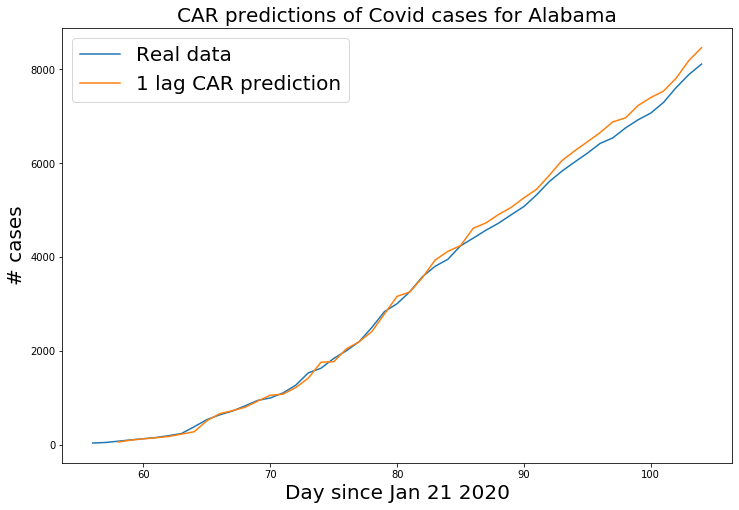

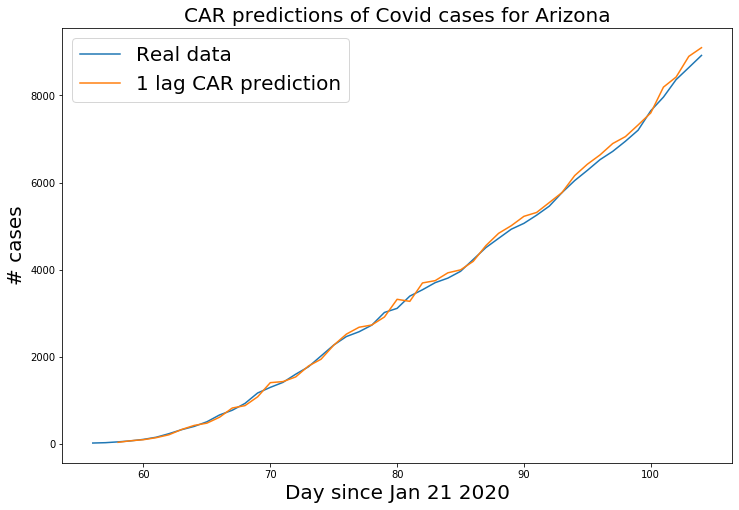

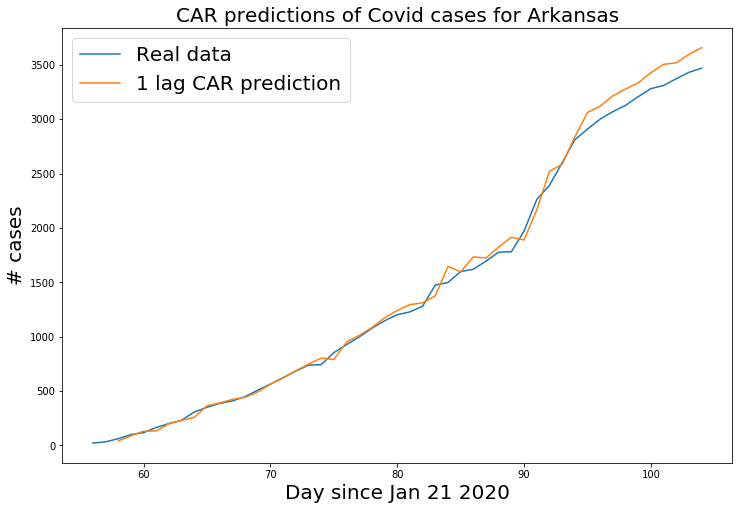

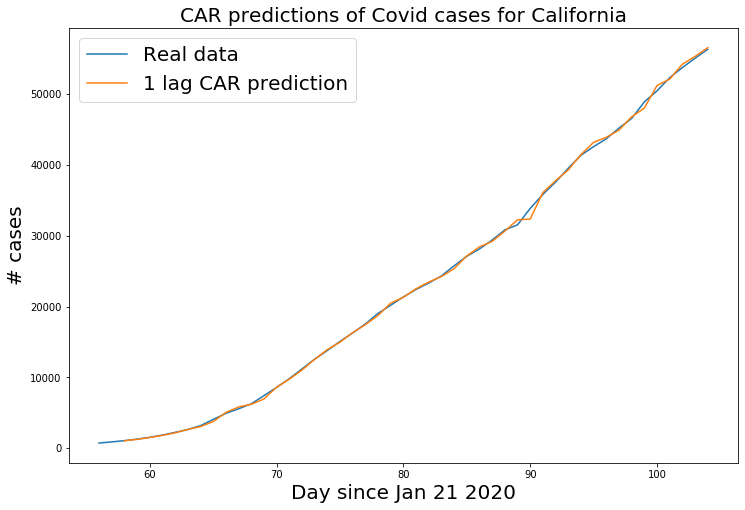

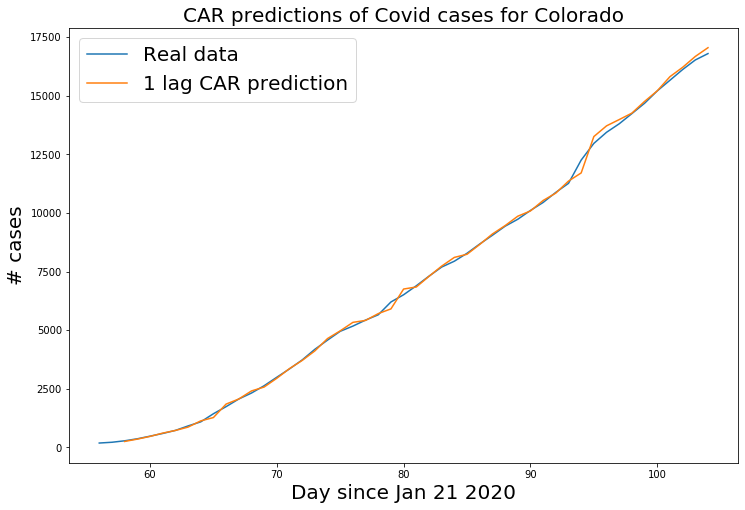

In [30]:
for state in covid_data.columns[:5]:
    plt.figure(figsize = (12,8))
    plt.plot(range(start, len(covid_data[state])), covid_data[state][start:], label = 'Real data')
    plt.plot(range(start+2, len(covid_data[state])),
                   predictions[state], label = '1 lag CAR prediction')
    plt.title('CAR predictions of Covid cases for {}'.format(state), fontsize = 20)
    plt.xlabel('Day since Jan 21 2020', fontsize = 20)
    plt.ylabel('# cases', fontsize = 20)
    plt.legend(fontsize = 20)
    plt.show()

Text(0.5, 1.0, 'Phi for all districts')

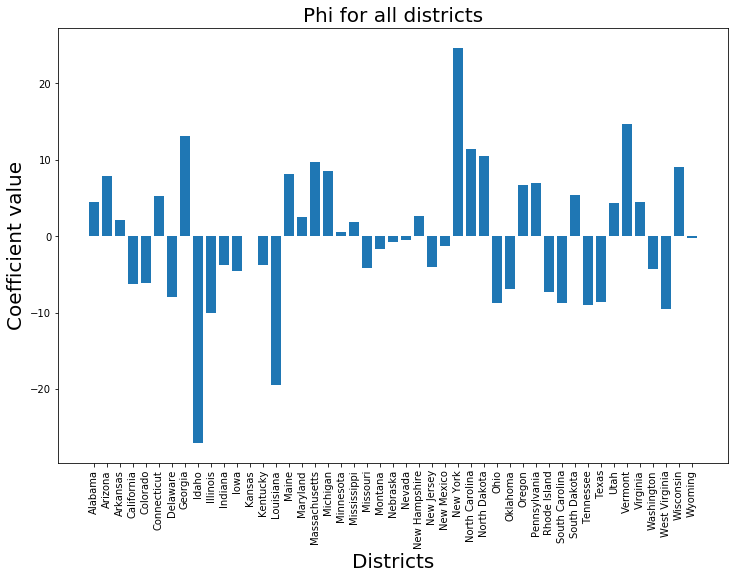

In [31]:
phis = [summ['mean']['phi[{}]'.format(i)] for i in range(47)]
beta1s = [summ['mean']['betas[{}]'.format(i)] for i in range(47)]

plt.figure(figsize = (12,8))
plt.bar(range(47), phis)
plt.xticks(range(47), covid_data.columns, rotation = 'vertical')
plt.xlabel('Districts', fontsize = 20)
plt.ylabel('Coefficient value',  fontsize = 20)
plt.title('Phi for all districts',  fontsize = 20)

Text(0.5, 1.0, 'CAR model parameters per state')

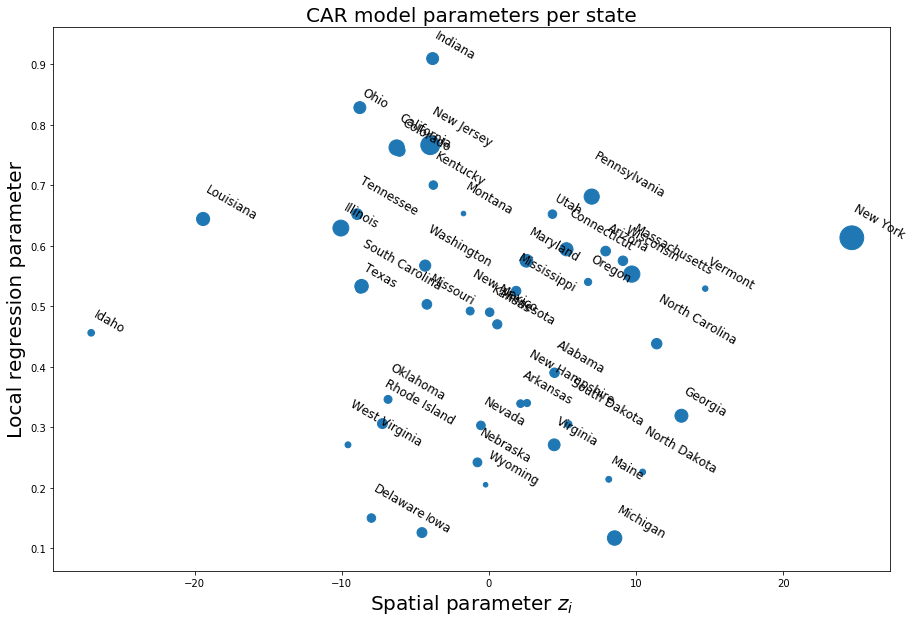

In [32]:
# get size proportional to last number of cases
sizes = np.array([np.sqrt(covid_data[state].iloc[-1]) for state in covid_data.columns])
norm_size = 0.0001*sizes/np.max(sizes)

plt.figure(figsize=(15, 10))
plt.scatter(phis, beta1s, s=sizes)
for i, state in enumerate(covid_data.columns):
    plt.annotate(state, (phis[i], beta1s[i]), rotation=-30, size=12)
plt.xlabel('Spatial parameter $z_i$', fontsize = 20)
plt.ylabel('Local regression parameter', fontsize = 20)
plt.title('CAR model parameters per state', fontsize = 20)

Let's now do 5 days ahead predictions using last five day information! 

In [25]:
lag = 5
pred_ahead = 5

# let's start from day 56 to avoid too many NaNs
start = 57
state2idx = {name : int(idx) for idx, name in enumerate(covid_data.columns)}

# create DF
CAR_df = pd.DataFrame(columns = ['Y_true_ahead', 'Y_true_before', 'Y_perc'] + 
                      ['State ID'] + ['X_lag{}'.format(i) for i in range(1, lag+1)])

row_num = 0
for i, day in enumerate(range(start + lag, len(covid_data) - pred_ahead)):
    for state in covid_data.columns:
        # do Y percentage increase and X last percentage increase
        Y_true_ahead = covid_data[state][day + pred_ahead]
        Y_true_before = covid_data[state][day]
        pred_Y = Y_true_ahead/Y_true_before
        lag_X = [covid_data[state][day - step]/covid_data[state][day - step -1] for step in range(1, lag+1)]
        CAR_df.loc[row_num] = [Y_true_ahead, Y_true_before, pred_Y] + [state2idx[state]] + lag_X
        row_num += 1

CAR_df.head()

,Y_true_ahead,Y_true_before,Y_perc,State ID,X_lag1,X_lag2,X_lag3,X_lag4,X_lag5
0,720.0,196.0,3.673469,0.0,1.198473,1.235849,1.358974,1.529412,1.307692
1,773.0,234.0,3.303419,1.0,1.471154,1.485714,1.489362,1.678571,1.400000
2,409.0,201.0,2.034826,2.0,1.398305,1.180000,1.612903,1.878788,1.500000
3,5565.0,2240.0,2.484375,3.0,1.198834,1.203429,1.202437,1.194849,1.219945
4,2061.0,721.0,2.858530,4.0,1.244211,1.304945,1.309353,1.287037,1.180328


In [26]:
df_train, df_test = train_test_split(CAR_df, test_size=0.2, random_state=42)

In [27]:
N = 47

with pm.Model() as model3:
    # Vague prior on intercept
    beta0 = pm.Normal('beta0', mu=0.0, tau=1.0e-5, shape = N)
    # Prior on local time regression
    betas = pm.Normal('betas', mu=0.0, tau = 1.0e-5, shape = lag)

    # Random effects (hierarchial) prior
    tau_h = pm.distributions.continuous.Gamma('tau_h', alpha=3.2761, beta=1.81)
    # Spatial clustering prior
    tau_c = pm.distributions.continuous.Gamma('tau_c', alpha=1.0, beta=1.0)
    
    Z = pm.Normal('Z_aux', mu = 0.0, sigma = 1.0, shape = len(df_train))
    theta = Z/np.sqrt(tau_h)
    
    # Regional random effects
    #theta = pm.Normal('theta', mu=0.0, tau=tau_h, shape=len(df_train))
    mu_phi = CAR2('mu_phi', w=wmat2, a=amat2, tau=1.0e-5, shape=N)

    # Zero-centre phi
    phi = pm.Deterministic('phi', mu_phi-tt.mean(mu_phi))

    # Mean model
    CAR_model_combo = beta0[np.array([int(i) for i in df_train['State ID'].values])]
    for i in range(lag):
        CAR_model_combo += betas[i]*df_train['X_lag{}'.format(i+1)].values
    CAR_model_combo += phi[np.array([int(i) for i in df_train['State ID'].values])]
    CAR_model_combo += theta
    mu = pm.Deterministic('mu', tt.exp(CAR_model_combo))

    # Likelihood
    tau_final = pm.distributions.continuous.Gamma('tau_final', alpha=0.1, beta=0.1)
    Yi = pm.Normal('Yi', mu=mu, tau = tau_final, observed=df_train['Y_perc'])

    # Marginal SD of heterogeniety effects
    sd_h = pm.Deterministic('sd_h', tt.std(theta))
    # Marginal SD of clustering (spatial) effects
    sd_c = pm.Deterministic('sd_c', tt.std(phi))
    # Proportion sptial variance
    alpha = pm.Deterministic('alpha', sd_c/(sd_h+sd_c))

In [36]:
with model3:
    print(f'Starting MCMC process') 
    trace3 = pm.sample(2000, tune=800, target_accept=0.98, cores = 8, max_treedepth = 12, init='adapt_diag')
    print(f'DONE')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


Starting MCMC process


Multiprocess sampling (8 chains in 8 jobs)
NUTS: [tau_final, mu_phi, Z_aux, tau_c, tau_h, betas, beta0]
Sampling 8 chains, 0 divergences: 100%|██████████| 22400/22400 [4:27:01<00:00,  1.40draws/s]  
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Inc

DONE


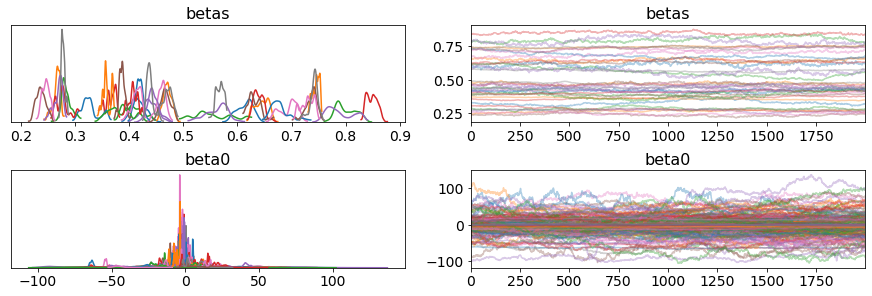

In [37]:
pm.traceplot(trace3, var_names=['betas', 'beta0']);

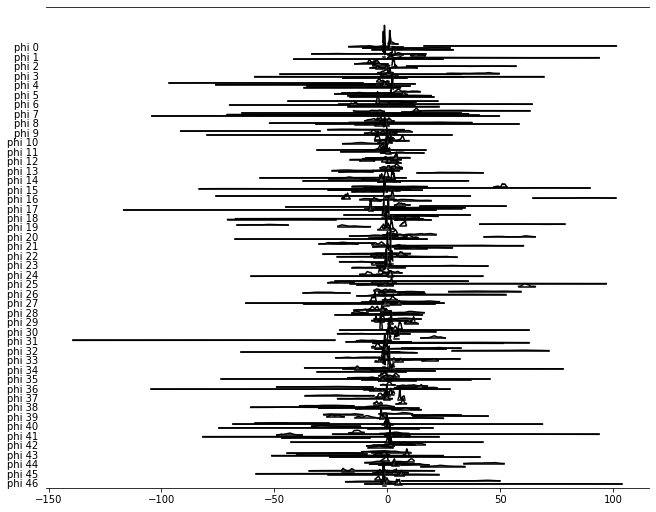

In [38]:
pm.plot_forest(trace3,
               kind='ridgeplot',
               var_names=['phi'],
               combined=False,
               ridgeplot_overlap=3,
               ridgeplot_alpha=.25,
               colors='white',
               figsize=(9, 7));

In [39]:
summ = pm.summary(trace3)
summ.to_csv('CARModelLag5')
summ

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta0[0],-9.977,19.800,-54.015,14.345,6.620,4.843,9.0,9.0,10.0,11.0,2.42
beta0[1],-7.614,18.376,-33.205,29.635,5.519,4.010,11.0,11.0,11.0,13.0,2.09
beta0[2],-4.466,13.333,-34.524,11.181,4.555,3.337,9.0,9.0,9.0,10.0,2.89
beta0[3],-9.275,20.220,-51.921,25.465,5.694,4.298,13.0,12.0,14.0,20.0,2.13
beta0[4],17.694,24.879,-6.358,76.777,8.017,5.850,10.0,10.0,11.0,25.0,1.93
...,...,...,...,...,...,...,...,...,...,...,...
mu[1427],1.204,0.043,1.128,1.284,0.005,0.004,66.0,66.0,64.0,248.0,1.09
tau_final,436.167,124.101,259.595,699.761,33.023,23.850,14.0,14.0,12.0,32.0,1.79
sd_h,0.134,0.001,0.132,0.136,0.000,0.000,23.0,23.0,23.0,92.0,1.26
sd_c,19.600,4.192,12.758,27.608,1.348,0.988,10.0,10.0,10.0,12.0,2.24


In [33]:
summ = pd.read_csv('CARModelLag5')
summ.set_index('Unnamed: 0', inplace = True)
summ

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Unnamed: 0,,,,,,,,,,,
beta0[0],-9.977,19.800,-54.015,14.345,6.620,4.843,9.0,9.0,10.0,11.0,2.42
beta0[1],-7.614,18.376,-33.205,29.635,5.519,4.010,11.0,11.0,11.0,13.0,2.09
beta0[2],-4.466,13.333,-34.524,11.181,4.555,3.337,9.0,9.0,9.0,10.0,2.89
beta0[3],-9.275,20.220,-51.921,25.465,5.694,4.298,13.0,12.0,14.0,20.0,2.13
beta0[4],17.694,24.879,-6.358,76.777,8.017,5.850,10.0,10.0,11.0,25.0,1.93
...,...,...,...,...,...,...,...,...,...,...,...
mu[1427],1.204,0.043,1.128,1.284,0.005,0.004,66.0,66.0,64.0,248.0,1.09
tau_final,436.167,124.101,259.595,699.761,33.023,23.850,14.0,14.0,12.0,32.0,1.79
sd_h,0.134,0.001,0.132,0.136,0.000,0.000,23.0,23.0,23.0,92.0,1.26


In [34]:
# prediction
# let's save the parameters for each state into a dict
params_dict = dict()
for k in range(47):
    params_k = [summ['mean']['beta0[{}]'.format(k)], 
                summ['mean']['phi[{}]'.format(k)]]
    params_dict[k] = params_k

In [38]:
# let's predict on the training data
y_train_pred = []

for i in range(len(df_train)):
    state = df_train['State ID'].iloc[i]
    params = params_dict[state]
    log_pred = params[0]
    for j in range(lag):
        log_pred += summ['mean']['betas[{}]'.format(j)]*df_train['X_lag{}'.format(j+1)].iloc[i] 
    log_pred += params[1]
    pred_perc = np.exp(log_pred)
    Y_true_pred = pred_perc*df_train['Y_true_before'].iloc[i]
    y_train_pred.append(Y_true_pred)
    
mse_train = mean_squared_error(y_train_pred, df_train['Y_true_ahead'])
print('RMSE on the training set: {}'.format(np.round(np.sqrt(mse_train), 4)))

y_test_pred = []

for i in range(len(df_test)):
    state = df_test['State ID'].iloc[i]
    params = params_dict[state]
    log_pred = params[0]
    for j in range(lag):
        log_pred += summ['mean']['betas[{}]'.format(j)]*df_train['X_lag{}'.format(j+1)].iloc[i] 
    log_pred += params[1]
    pred_perc = np.exp(log_pred)
    Y_true_pred = pred_perc*df_test['Y_true_before'].iloc[i]
    y_test_pred.append(Y_true_pred)

y_test_true = [k if not math.isnan(k) else 0.0 for k in df_test['Y_true_ahead']]
y_test_pred = [k if not math.isnan(k) else 0.0 for k in y_test_pred]
mse_test = mean_squared_error(y_test_pred, y_test_true)
print('RMSE on the test set: {}'.format(np.round(np.sqrt(mse_test), 4)))

RMSE on the training set: 2495.1877
RMSE on the test set: 11488.4595


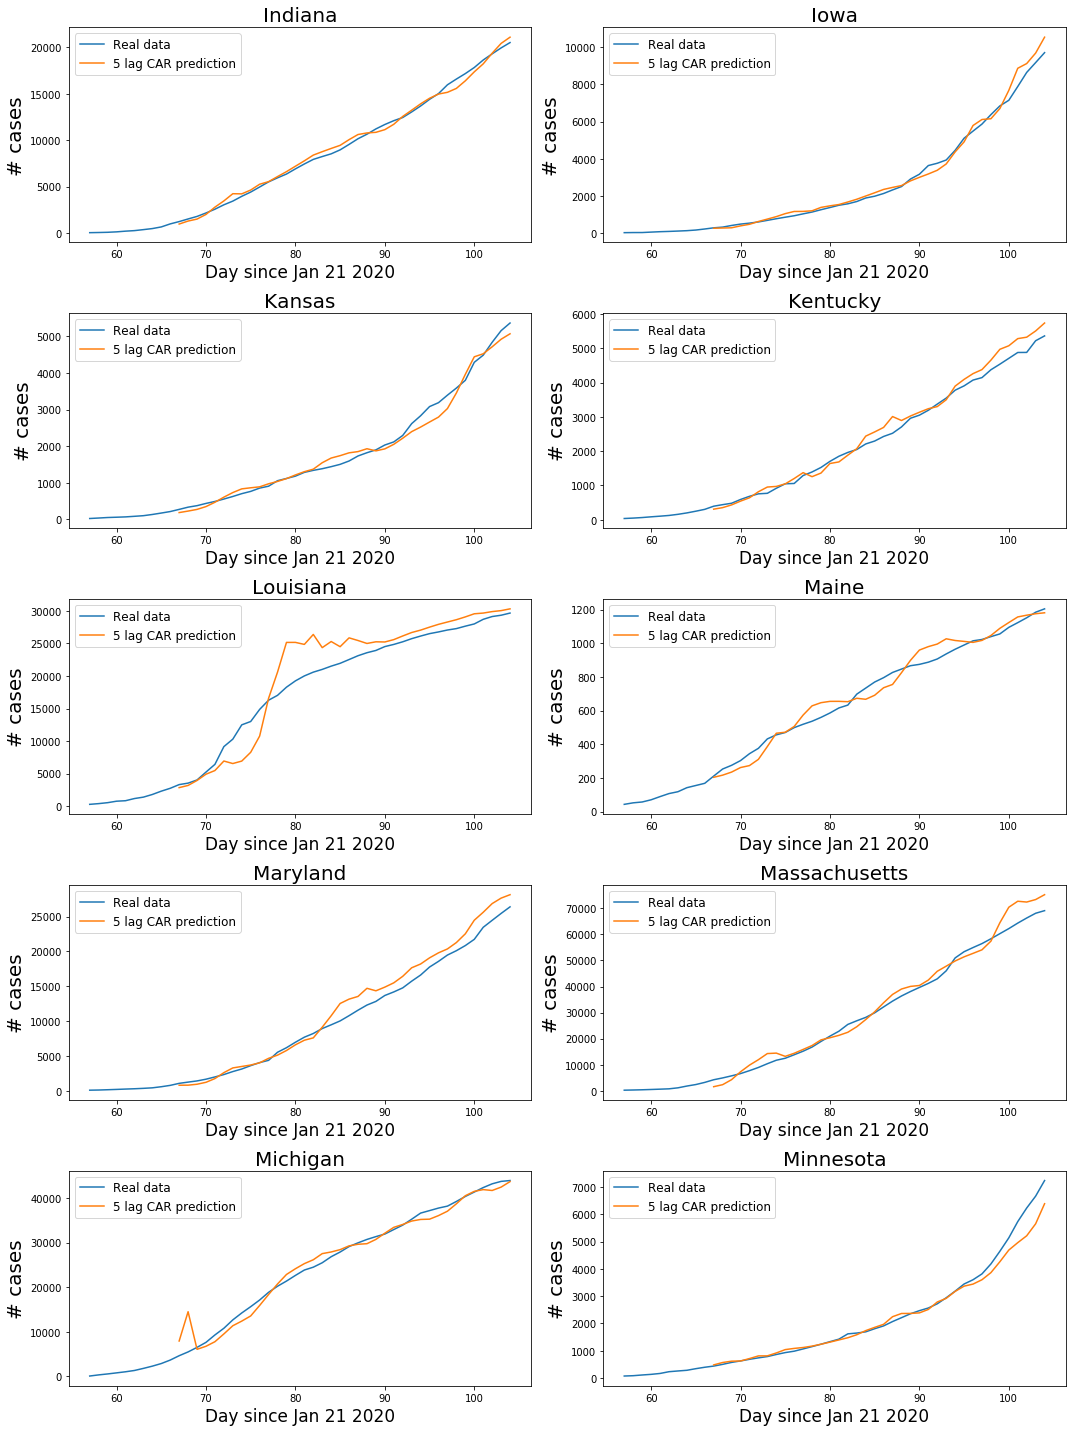

In [88]:
predictions = dict()

for state_id, state in enumerate(covid_data.columns):
    pred_state = []
    for i, day in enumerate(range(start + lag, len(covid_data) - pred_ahead)):
        params = params_dict[state_id]
        lag_X = [covid_data[state][day - step]/covid_data[state][day - step -1] for step in range(1, lag+1)]
        log_pred = params[0] 
        for j in range(lag):
            log_pred += summ['mean']['betas[{}]'.format(j)]*lag_X[j]
        log_pred += params[1]
        pred = np.exp(log_pred)
        T_pred = pred*covid_data[state][day]
        pred_state.append(T_pred)
    predictions[state] = pred_state
    
fig, ax = plt.subplots(5,2, figsize = (15,20))

for i, state in enumerate(covid_data.columns[10:20]):
    ax[int(i/2), i%2].plot(range(start, len(covid_data[state])), covid_data[state][start:], label = 'Real data')
    ax[int(i/2), i%2].plot(range(start+lag+pred_ahead, len(covid_data[state])),
                   predictions[state], label = '5 lag CAR prediction')
    ax[int(i/2), i%2].set_title('{}'.format(state), fontsize = 20)
    ax[int(i/2), i%2].set_xlabel('Day since Jan 21 2020', fontsize = 17)
    ax[int(i/2), i%2].set_ylabel('# cases', fontsize = 20)
    ax[int(i/2), i%2].legend(fontsize = 12)
    
plt.tight_layout()

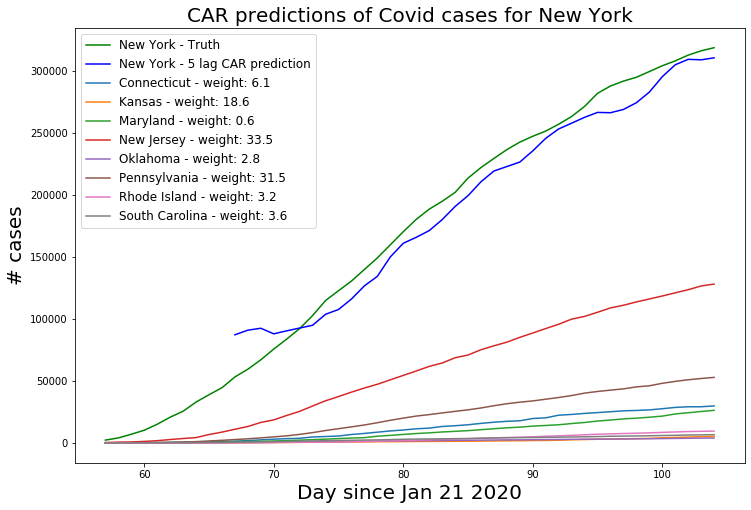

In [77]:
# let's see what the impact is of the neighbours on the prediction

idx = 28
state = covid_data.columns[idx]

plt.figure(figsize = (12,8))
plt.plot(range(start, len(covid_data[state])), covid_data[state][start:], label = '{} - Truth'.format(state),
        c = 'green')
plt.plot(range(start+lag+pred_ahead, len(covid_data[state])),
                   predictions[state], label = '{} - 5 lag CAR prediction'.format(state), c = 'blue')

for i, neighb_weight in enumerate(wmat2[28,:]):
    if neighb_weight != 0:
        neighb_state = covid_data.columns[i]
        rel_weight = np.round(100*neighb_weight/np.sum(wmat2[28,:]), 1)
        plt.plot(range(start, len(covid_data[neighb_state])), covid_data[neighb_state][start:], 
                 label = '{} - weight: {}'.format(neighb_state, rel_weight))
            
plt.title('CAR predictions of Covid cases for {}'.format(state), fontsize = 20)
plt.xlabel('Day since Jan 21 2020', fontsize = 20)
plt.ylabel('# cases', fontsize = 20)
plt.legend(fontsize = 12)
plt.show()

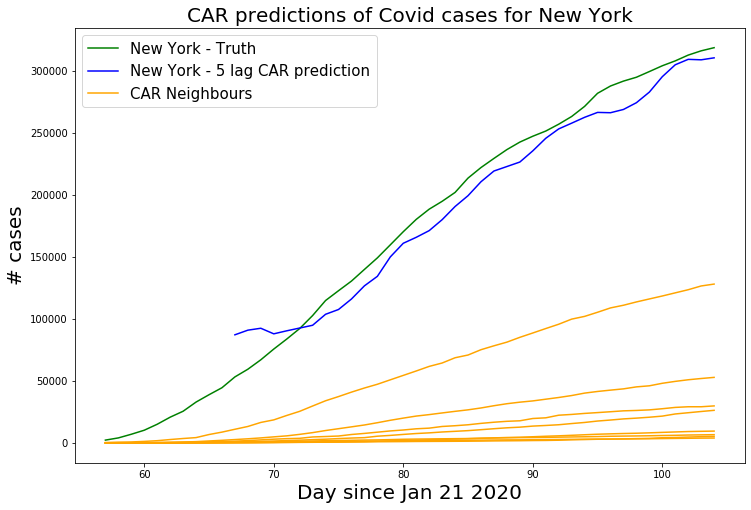

In [67]:
# let's see what the impact is of the neighbours on the prediction

idx = 28
state = covid_data.columns[idx]

plt.figure(figsize = (12,8))
plt.plot(range(start, len(covid_data[state])), covid_data[state][start:], label = '{} - Truth'.format(state),
        c = 'green')
plt.plot(range(start+lag+pred_ahead, len(covid_data[state])),
                   predictions[state], label = '{} - 5 lag CAR prediction'.format(state), c = 'blue')

neigh_cnt = 0
for i, neighb_weight in enumerate(wmat2[28,:]):
    if neighb_weight != 0:
        neighb_state = covid_data.columns[i]
        rel_weight = neighb_weight/np.sum(wmat2[28,:])
        if neigh_cnt == 0:
            plt.plot(range(start, len(covid_data[neighb_state])), covid_data[neighb_state][start:], 
                     label = 'CAR Neighbours', c = 'orange')
        else:
            plt.plot(range(start, len(covid_data[neighb_state])), covid_data[neighb_state][start:], 
                     c = 'orange')
        neigh_cnt += 1
            
plt.title('CAR predictions of Covid cases for {}'.format(state), fontsize = 20)
plt.xlabel('Day since Jan 21 2020', fontsize = 20)
plt.ylabel('# cases', fontsize = 20)
plt.legend(fontsize = 15)
plt.show()

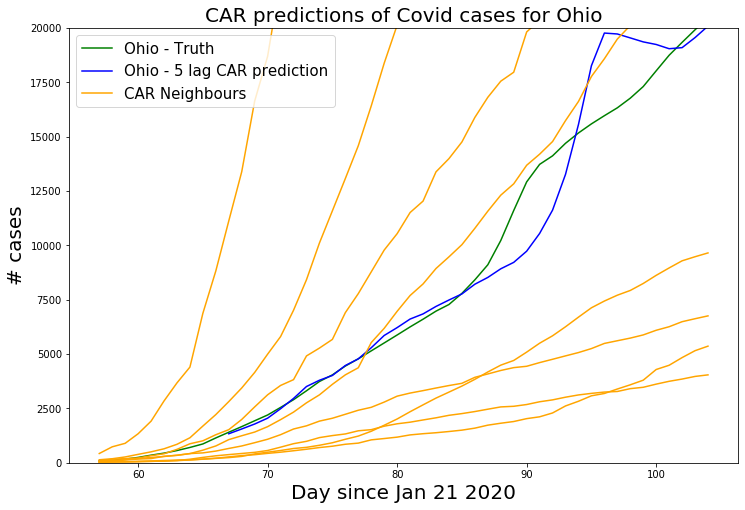

In [74]:
# let's see what the impact is of the neighbours on the prediction

idx = 31
state = covid_data.columns[idx]

plt.figure(figsize = (12,8))
plt.plot(range(start, len(covid_data[state])), covid_data[state][start:], label = '{} - Truth'.format(state),
        c = 'green')
plt.plot(range(start+lag+pred_ahead, len(covid_data[state])),
                   predictions[state], label = '{} - 5 lag CAR prediction'.format(state), c = 'blue')

neigh_cnt = 0
for i, neighb_weight in enumerate(wmat2[28,:]):
    if neighb_weight != 0:
        neighb_state = covid_data.columns[i]
        rel_weight = neighb_weight/np.sum(wmat2[28,:])
        if neigh_cnt == 0:
            plt.plot(range(start, len(covid_data[neighb_state])), covid_data[neighb_state][start:], 
                     label = 'CAR Neighbours', c = 'orange')
        else:
            plt.plot(range(start, len(covid_data[neighb_state])), covid_data[neighb_state][start:], 
                     c = 'orange')
        neigh_cnt += 1
            
plt.title('CAR predictions of Covid cases for {}'.format(state), fontsize = 20)
plt.xlabel('Day since Jan 21 2020', fontsize = 20)
plt.ylabel('# cases', fontsize = 20)
plt.ylim(0,20000)
plt.legend(fontsize = 15)
plt.show()

In [115]:
# let's find a measure of overpredicting
overpreds = dict()
for idx, state in enumerate(covid_data.columns):
    truth = np.array(covid_data[state][start+lag+pred_ahead:])
    pred = predictions[state]
    overpreds[state] = np.mean([pred[k] - truth[k] for k in range(len(pred))])/np.mean(truth)

In [89]:
# let's get the test rates
test_data = pd.read_csv('TestRates.csv')
test_data.head()

,state,positive,positiveScore,negativeScore,negativeRegularScore,commercialScore,grade,score,notes,dataQualityGrade,...,checkTimeEt,death,hospitalized,total,totalTestResults,posNeg,fips,dateModified,dateChecked,hash
0,AK,377,1.0,1.0,1.0,1.0,A,4.0,"Please stop using the ""total"" field. Use ""tota...",C,...,5/08 16:17,10,NaN,25473,25473,25473,2,2020-05-08T04:00:00Z,2020-05-08T20:17:00Z,359d7caae8003430cab7ae640201799a78153394
1,AL,9221,1.0,1.0,0.0,1.0,B,3.0,"Please stop using the ""total"" field. Use ""tota...",B,...,5/08 16:17,375,1207.0,120114,120114,120114,1,2020-05-08T04:00:00Z,2020-05-08T20:17:00Z,2f2783166bf83be747de4f63e6bb311bf53b35ec
2,AR,3694,1.0,1.0,1.0,1.0,A,4.0,"Please stop using the ""total"" field. Use ""tota...",B,...,5/08 15:14,88,466.0,63994,63994,63994,5,2020-05-08T12:15:00Z,2020-05-08T19:14:00Z,44c8dec1ac6c68ca90d49dbd1405484447a8b740
3,AZ,10526,1.0,1.0,0.0,1.0,B,3.0,"Please stop using the ""total"" field. Use ""tota...",A+,...,5/08 14:43,517,1482.0,119907,119907,119907,4,2020-05-08T04:00:00Z,2020-05-08T18:43:00Z,8439256def5bc17a88c19db7ee3b8aaa6e35041d
4,CA,62512,1.0,1.0,0.0,1.0,B,3.0,"Please stop using the ""total"" field. Use ""tota...",B,...,5/08 15:16,2585,NaN,875272,875272,875272,6,2020-05-08T18:00:00Z,2020-05-08T19:16:00Z,03dfa95a8fa0dfa6daf98863e624d55af434dfde


In [98]:
state_name2abbrev = {
    'Alabama':'AL','Alaska':'AK','Arizona':'AZ','Arkansas':'AR','California':'CA', 
    'Colorado':'CO','Connecticut':'CT','Delaware':'DE','Florida':'FL','Georgia':'GA',
    'Hawaii':'HI','Idaho':'ID','Illinois':'IL','Indiana':'IN','Iowa':'IA','Kansas':'KS',
    'Kentucky':'KY','Louisiana':'LA','Maine':'ME','Maryland':'MD','Massachusetts':'MA',
    'Michigan':'MI','Minnesota':'MN','Mississippi':'MS','Missouri':'MO','Montana':'MT',
    'Nebraska':'NE','Nevada':'NV','New Hampshire':'NH','New Jersey':'NJ','New Mexico':'NM',
    'New York':'NY','North Carolina':'NC','North Dakota':'ND','Ohio':'OH','Oklahoma':'OK',
    'Oregon':'OR','Pennsylvania':'PA','Rhode Island':'RI','South Carolina':'SC',
    'South Dakota':'SD','Tennessee':'TN','Texas':'TX','Utah':'UT','Vermont':'VT',
    'Virginia':'VA','Washington':'WA','West Virginia':'WV','Wisconsin':'WI','Wyoming':'WY'
}

abbrev2state_name = {state_name2abbrev[key]: key for key in state_name2abbrev.keys()}
test_rates = dict()

for i, state_abbrev in enumerate(test_data['state']):
    test_rate = 100*test_data['positive'].iloc[i]/test_data['total'].iloc[i]
    if state_abbrev in abbrev2state_name.keys():
        state_name = abbrev2state_name[state_abbrev]
        test_rates[state_name] = test_rate
    else:
        print(state_abbrev)

DC
PR
AS
GU
MP
VI


Text(0.5, 1.0, 'Positive test rate for Covid for all US states')

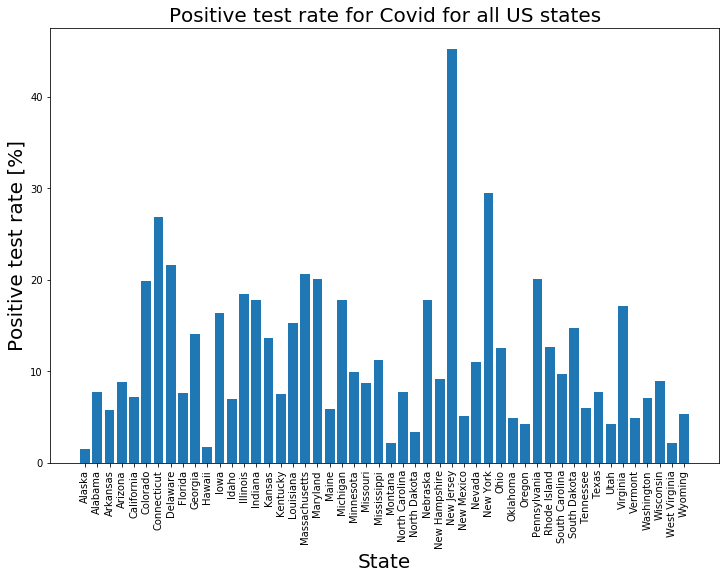

In [100]:
plt.figure(figsize = (12,8))
plt.bar(range(len(test_rates)), test_rates.values())
plt.xticks(range(len(test_rates)), test_rates.keys(), rotation = 'vertical')
plt.xlabel('State', fontsize = 20)
plt.ylabel('Positive test rate [%]',  fontsize = 20)
plt.title('Positive test rate for Covid for all US states',  fontsize = 20)

In [114]:
overpreds

{'Alabama': 160.02716435176026,
 'Arizona': -177.61157794876476,
 'Arkansas': -25.34935660112848,
 'California': 1491.4244497142324,
 'Colorado': 153.71319383460744,
 'Connecticut': 537.2331181298209,
 'Delaware': 61.86490289729667,
 'Georgia': 252.8247642171726,
 'Idaho': 115.61062669187928,
 'Illinois': 346.10101337607796,
 'Indiana': 64.09382205416948,
 'Iowa': 94.07465059314937,
 'Kansas': -31.195469218475665,
 'Kentucky': 117.29902949176515,
 'Louisiana': 996.7755599640678,
 'Maine': 7.453999727709835,
 'Maryland': 917.7976822389867,
 'Massachusetts': 1210.0885431543677,
 'Michigan': 8.626969367147131,
 'Minnesota': -118.0223570253945,
 'Mississippi': -127.48961413547084,
 'Missouri': -5.183022206533714,
 'Montana': 7.066257734832412,
 'Nebraska': 96.27051499424041,
 'Nevada': 64.41112050255259,
 'New Hampshire': 45.15235527601862,
 'New Jersey': 1199.0698386357374,
 'New Mexico': 52.5581176844945,
 'New York': -7168.064688682654,
 'North Carolina': -35.865315751610375,
 'North Da

Text(0.5, 1.0, 'Covid test rate vs CAR overpredicting rate')

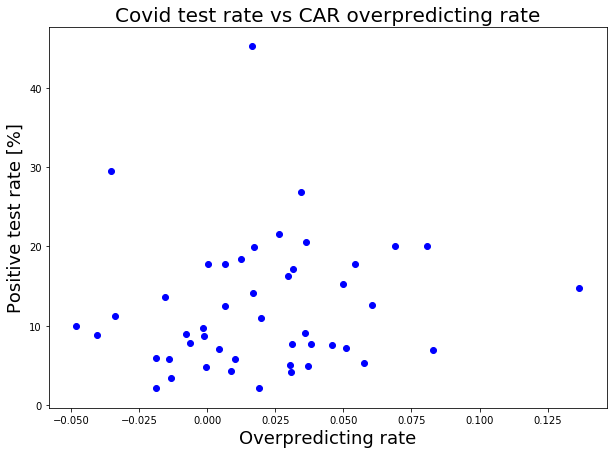

In [121]:
plt.figure(figsize = (10,7))

for state in covid_data.columns:
    overprediction = overpreds[state]
    test_rate = test_rates[state]
    plt.scatter(overprediction, test_rate, c = 'blue')
plt.ylabel('Positive test rate [%]', fontsize = 18)
plt.xlabel('Overpredicting rate', fontsize = 18)
plt.title('Covid test rate vs CAR overpredicting rate', fontsize = 20)

In [ ]:
with model3:
    print(f'Starting MCMC process') 
    trace4 = pm.sample(2000, tune=800, target_accept=0.98, cores = 8, max_treedepth = 14, init='adapt_diag')
    print(f'DONE')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


Starting MCMC process


Multiprocess sampling (8 chains in 8 jobs)
NUTS: [tau_final, mu_phi, Z_aux, tau_c, tau_h, betas, beta0]
Sampling 8 chains, 0 divergences:  10%|▉         | 2231/22400 [31:22<21:10:51,  3.78s/draws]

In [ ]:
pm.traceplot(trace4, var_names=['betas', 'beta0']);

In [ ]:
pm.plot_forest(trace4,
               kind='ridgeplot',
               var_names=['phi'],
               combined=False,
               ridgeplot_overlap=3,
               ridgeplot_alpha=.25,
               colors='white',
               figsize=(9, 7));

In [ ]:
summ = pm.summary(trace4)
summ.to_csv('CARModelLag5_V2')
summ